# Random Forest Simulation

### Data preparation

In [327]:
import numpy as np
import pandas as pd 
import sys
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


# Get the ranking Data
rankings = pd.read_csv("https://raw.githubusercontent.com/rajeevratan84/data-analyst-bootcamp/master/fifa_ranking.csv")
rankings = rankings.loc[:,['rank', 'country_full', 'country_abrv', 'cur_year_avg_weighted', 'rank_date', 
                           'two_year_ago_weighted', 'three_year_ago_weighted']]

# Fix some country names
rankings = rankings.replace({"IR Iran": "Iran"})
# Get weighted points by summing cur_year_avg_weighted + two_year_ago_weighted + three_year_ago_weighted
rankings['weighted_points'] =  rankings['cur_year_avg_weighted'] + rankings['two_year_ago_weighted'] + rankings['three_year_ago_weighted']
rankings['rank_date'] = pd.to_datetime(rankings['rank_date']) # change to pandas datetime format

# Get the match Data
matches = pd.read_csv("https://raw.githubusercontent.com/rajeevratan84/data-analyst-bootcamp/master/results.csv")

# Fix some country names
matches =  matches.replace({'Germany DR': 'Germany', 'China': 'China PR'})
matches['date'] = pd.to_datetime(matches['date'])

# Get the world cup fixture data
world_cup = pd.read_csv("https://raw.githubusercontent.com/rajeevratan84/data-analyst-bootcamp/master/WorldCup2018Dataset.csv")

# extract relavent columns
world_cup = world_cup.loc[:, ['Team', 'Group', 'First match \nagainst', 'Second match\n against', 'Third match\n against']]

# Drop NAs
world_cup = world_cup.dropna(how='all')

# Fix some country names
world_cup = world_cup.replace({"IRAN": "Iran", 
                               "Costarica": "Costa Rica", 
                               "Porugal": "Portugal", 
                               "Columbia": "Colombia", 
                               "Korea" : "Korea Republic"})
# set index to team 
world_cup = world_cup.set_index('Team')

# Extract elo rating
elo_rating = pd.read_csv("/Users/JISOO/Desktop/STAT3011-Group5-Project2/elo_rating-1992-2022.csv")
elo_rating = elo_rating.replace({"China": "China PR", 
                                 "Congo": "Congo PR", 
                                 "North Korea": "Korea DPR", 
                                 "United States": "USA", 
                                 "South Korea" : "Korea Republic", 
                                 "Turks and Caicos" : "Turks and Caicos Islands"})

# Convert the 'year' column in the 'elo_rating' DataFrame to integer
elo_rating['year'] = elo_rating['year'].astype(int)

In [328]:
# we want to have the ranks for every day 
# We use resample to sample by Day and get the first date
rankings = rankings.set_index(['rank_date'])\
            .groupby(['country_full'], group_keys=False)\
            .resample('D').first()\
            .fillna(method='ffill')\
            .reset_index()

# join the ranks
# First we do it for the Home team
matches = matches.merge(rankings, 
                        left_on=['date', 'home_team'], 
                        right_on=['rank_date', 'country_full'])

# Next we do it for the Away teams
matches = matches.merge(rankings, 
                        left_on=['date', 'away_team'], 
                        right_on=['rank_date', 'country_full'], 
                        suffixes=('_home', '_away'))

# feature generation
matches['rank_difference'] = matches['rank_home'] - matches['rank_away']
matches['average_rank'] = (matches['rank_home'] + matches['rank_away'])/2
matches['point_difference'] = matches['weighted_points_home'] - matches['weighted_points_away']
matches['score_difference'] = matches['home_score'] - matches['away_score']
matches['is_won'] = matches['score_difference'] > 0 # take draw as lost

In [329]:
# Add year column to matches
matches['year'] = matches['date'].dt.year

# Merge elo_rating DataFrame
matches = matches.merge(elo_rating, left_on=['year', 'home_team'], right_on=['year', 'country'], suffixes=('_home', '_away'))
matches = matches.merge(elo_rating, left_on=['year', 'away_team'], right_on=['year', 'country'], suffixes=('_home', '_away'))

matches['elo_rating_difference'] = matches['elo_home'] - matches['elo_away']


In [330]:
X = matches.loc[:, ['average_rank', 'rank_difference', 'point_difference', 'elo_rating_difference']]
y = matches['is_won']

# Create our test and train datasets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [331]:
X

,average_rank,rank_difference,point_difference,elo_rating_difference
0,40.5,37.0,0.00,-300
1,15.0,-14.0,0.00,149
2,28.5,13.0,0.00,-206
3,10.0,-10.0,0.00,143
4,47.0,24.0,0.00,-94
...,...,...,...,...
18111,56.5,-103.0,679.13,490
18112,41.0,28.0,-228.71,-3
18113,26.0,-2.0,-20.25,71
18114,121.5,-9.0,65.35,-60


Confusion matrix:
 [[1317  557]
 [ 602 1148]]
Classification report:
               precision    recall  f1-score   support

       False       0.69      0.70      0.69      1874
        True       0.67      0.66      0.66      1750

    accuracy                           0.68      3624
   macro avg       0.68      0.68      0.68      3624
weighted avg       0.68      0.68      0.68      3624

Accuracy: 0.6801876379690949
ROC AUC score: 0.7399208720841592


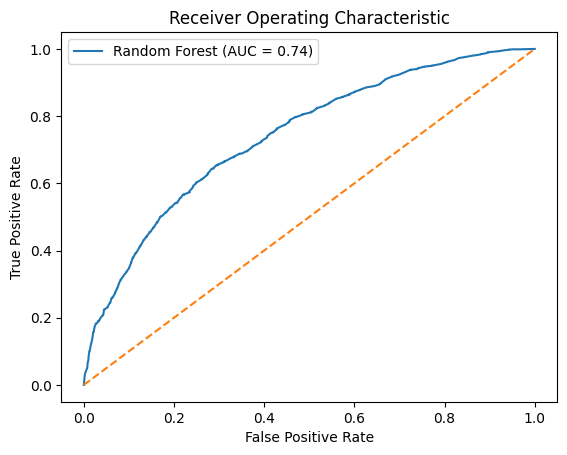

In [332]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve

# Create the Random Forest classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.set_params(**{'n_jobs':-1})

# Fit the classifier to the training data
rfc.fit(X_train, y_train)

# Predict on the test data
y_pred = rfc.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

# Compute the classification report
cr = classification_report(y_test, y_pred)
print("Classification report:\n", cr)

# Compute the accuracy of the classifier
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

# Compute the ROC AUC score and plot the ROC curve
roc_auc = roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1])
print("ROC AUC score:", roc_auc)

fpr, tpr, _ = roc_curve(y_test, rfc.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label='Random Forest (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()


In [334]:
# let's define a small margin that we add, so that we predict draws when probabilies lie between 0.475 and 0.525
margin = 0.025

# let's define the rankings at the time of the World Cup (so we sort on most recent rankings)
world_cup_rankings = rankings.loc[(rankings['rank_date'] == rankings['rank_date'].max()) & 
                                    rankings['country_full'].isin(world_cup.index.unique())]
world_cup_rankings = world_cup_rankings.set_index(['country_full'])

In [335]:
# Calculate average elo rating by country
elo_by_country = elo_rating.groupby('country')['elo'].mean().reset_index()

# Merge average elo rating with world_cup_rankings
world_cup_rankings = world_cup_rankings.reset_index()
world_cup_rankings = world_cup_rankings.merge(elo_by_country, left_on=world_cup_rankings.columns[0], right_on='country', how='left')
world_cup_rankings = world_cup_rankings.set_index(['country_full'])
world_cup_rankings

,rank_date,rank,country_abrv,cur_year_avg_weighted,two_year_ago_weighted,three_year_ago_weighted,weighted_points,country,elo
country_full,,,,,,,,,
Argentina,2018-06-07,5.0,ARG,404.07,248.99,183.59,836.65,Argentina,1968.709677
Australia,2018-06-07,36.0,AUS,366.60,98.16,59.79,524.55,Australia,1753.354839
Belgium,2018-06-07,3.0,BEL,629.98,158.94,186.58,975.50,Belgium,1815.645161
Brazil,2018-06-07,2.0,BRA,558.95,168.06,162.38,889.39,Brazil,2057.903226
Colombia,2018-06-07,16.0,COL,292.09,199.73,166.38,658.20,Colombia,1846.193548
Costa Rica,2018-06-07,23.0,CRC,410.90,99.73,133.11,643.74,Costa Rica,1677.935484
Croatia,2018-06-07,20.0,CRO,397.75,100.79,110.25,608.79,Croatia,1876.225806
Denmark,2018-06-07,12.0,DEN,723.72,90.07,80.21,894.00,Denmark,1858.935484
Egypt,2018-06-07,45.0,EGY,208.27,99.48,50.64,358.39,Egypt,1664.580645


In [336]:
X

,average_rank,rank_difference,point_difference,elo_rating_difference
0,40.5,37.0,0.00,-300
1,15.0,-14.0,0.00,149
2,28.5,13.0,0.00,-206
3,10.0,-10.0,0.00,143
4,47.0,24.0,0.00,-94
...,...,...,...,...
18111,56.5,-103.0,679.13,490
18112,41.0,28.0,-228.71,-3
18113,26.0,-2.0,-20.25,71
18114,121.5,-9.0,65.35,-60


In [338]:
from itertools import combinations

opponents = ['First match \nagainst', 'Second match\n against', 'Third match\n against']

world_cup['points'] = 0
world_cup['total_prob'] = 0

# We iterate through each game in the schedule, doing each group at a time
for group in set(world_cup['Group']):
    print('___Starting group {}:___'.format(group))

    for home, away in combinations(world_cup.query('Group == "{}"'.format(group)).index, 2):
        print("{} vs. {}: ".format(home, away), end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, np.nan]]), columns=X_test.columns)

        # Get features for each team competiting in the fixture
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'weighted_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'weighted_points']
        home_elo = world_cup_rankings.loc[home, 'elo']
        away_elo = world_cup_rankings.loc[away, 'elo']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points
        row['elo_rating_difference'] = home_elo - away_elo
        
        # get the prediction probability of the home team winning
        home_win_prob = rfc.predict_proba(row)[:,1][0]
        world_cup.loc[home, 'total_prob'] += home_win_prob
        world_cup.loc[away, 'total_prob'] += 1-home_win_prob
        
        points = 0
        # Allocate points 
        if home_win_prob <= 0.5 - margin:
            print("{} wins with {:.2f}".format(away, 1-home_win_prob))
            world_cup.loc[away, 'points'] += 3
        if home_win_prob > 0.5 - margin:
            points = 1
        if home_win_prob >= 0.5 + margin:
            points = 3
            world_cup.loc[home, 'points'] += 3
            print("{} wins with {:.2f}".format(home, home_win_prob))
        if points == 1:
            print("Draw")
            world_cup.loc[home, 'points'] += 1
            world_cup.loc[away, 'points'] += 1


___Starting group D:___
Argentina vs. Iceland: Argentina wins with 0.71
Argentina vs. Croatia: Croatia wins with 0.79
Argentina vs. Nigeria: Argentina wins with 0.57
Iceland vs. Croatia: Iceland wins with 0.55
Iceland vs. Nigeria: Nigeria wins with 0.57
Croatia vs. Nigeria: Croatia wins with 0.57
___Starting group F:___
Germany vs. Mexico: Germany wins with 0.65
Germany vs. Sweden: Sweden wins with 0.59
Germany vs. Korea Republic: Korea Republic wins with 0.55
Mexico vs. Sweden: Draw
Mexico vs. Korea Republic: Mexico wins with 0.70
Sweden vs. Korea Republic: Sweden wins with 0.59
___Starting group A:___
Russia vs. Saudi Arabia: Russia wins with 0.62
Russia vs. Egypt: Egypt wins with 0.57
Russia vs. Uruguay: Uruguay wins with 0.84
Saudi Arabia vs. Egypt: Egypt wins with 0.73
Saudi Arabia vs. Uruguay: Uruguay wins with 0.93
Egypt vs. Uruguay: Uruguay wins with 0.91
___Starting group C:___
France vs. Australia: France wins with 0.71
France vs. Peru: France wins with 0.60
France vs. Denmar

In [339]:
# Hardcode the mappings
pairing = [0,3,4,7,8,11,12,15,1,2,5,6,9,10,13,14]

world_cup = world_cup.sort_values(by=['Group', 'points', 'total_prob'], ascending=False).reset_index()
next_round_wc = world_cup.groupby('Group').nth([0, 1]) # select the top 2
next_round_wc = next_round_wc.reset_index()
next_round_wc = next_round_wc.loc[pairing]
next_round_wc = next_round_wc.set_index('Team')

next_round_wc.sort_values(by='Group')

,Group,First match \nagainst,Second match\n against,Third match\n against,points,total_prob
Team,,,,,,
Uruguay,A,Egypt,Saudi Arabia,Russia,9,2.680000
Egypt,A,Uruguay,Russia,Saudi Arabia,6,1.391667
Portugal,B,Spain,Morocco,Iran,6,1.700000
Spain,B,Portugal,Iran,Morocco,6,1.850000
Denmark,C,Peru,Australia,France,9,1.900000
France,C,Australia,Peru,Denmark,6,1.770000
Argentina,D,Iceland,Croatia,Nigeria,6,1.490000
Croatia,D,Nigeria,Argentina,Iceland,6,1.810000
Brazil,E,Switzerland,Costa Rica,Serbia,9,1.725000


In [340]:
finals = ['round_of_16', 'quarterfinal', 'semifinal', 'final']

labels = list()
odds = list()

# for each knockout stage
for f in finals:
    print("___Starting of the {}___".format(f))
    iterations = int(len(next_round_wc) / 2)
    winners = []

    for i in range(iterations):
        # get the teams playing
        home = next_round_wc.index[i*2]
        away = next_round_wc.index[i*2+1]
        print("{} vs. {}: ".format(home,
                                   away), 
                                   end='')
        
        # get the features for each team
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'weighted_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'weighted_points']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points

        # Get the winner
        home_win_prob = rfc.predict_proba(row)[:,1][0]
        
        # Display resultes
        if rfc.predict_proba(row)[:,1] <= 0.5:
            print("{0} wins with probability {1:.2f}".format(away, 1-home_win_prob))
            winners.append(away)
        else:
            print("{0} wins with probability {1:.2f}".format(home, home_win_prob))
            winners.append(home)

        # Display winning team and probability of victory
        labels.append("{}({:.2f}) vs. {}({:.2f})".format(world_cup_rankings.loc[home, 'country_abrv'], 
                                                        1/home_win_prob, 
                                                        world_cup_rankings.loc[away, 'country_abrv'], 
                                                        1/(1-home_win_prob)))
        odds.append([home_win_prob, 1-home_win_prob])
                
    next_round_wc = next_round_wc.loc[winners]
    print("\n")

___Starting of the round_of_16___
Uruguay vs. Portugal: Portugal wins with probability 0.68
Denmark vs. Argentina: Argentina wins with probability 0.77
Brazil vs. Mexico: Brazil wins with probability 0.55
England vs. Japan: Japan wins with probability 0.54
Egypt vs. Spain: Spain wins with probability 0.56
France vs. Croatia: France wins with probability 0.56
Costa Rica vs. Sweden: Sweden wins with probability 0.77
Belgium vs. Colombia: Colombia wins with probability 0.60


___Starting of the quarterfinal___
Portugal vs. Argentina: Argentina wins with probability 0.80
Brazil vs. Japan: Japan wins with probability 0.64
Spain vs. France: France wins with probability 0.62
Sweden vs. Colombia: Colombia wins with probability 0.79


___Starting of the semifinal___
Argentina vs. Japan: Japan wins with probability 0.68
France vs. Colombia: France wins with probability 0.51


___Starting of the final___
Japan vs. France: France wins with probability 0.66




/var/folders/hm/f_2f7w212174qh26d8_r_npc0000gn/T/ipykernel_56357/3678938229.py:8: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog='twopi')


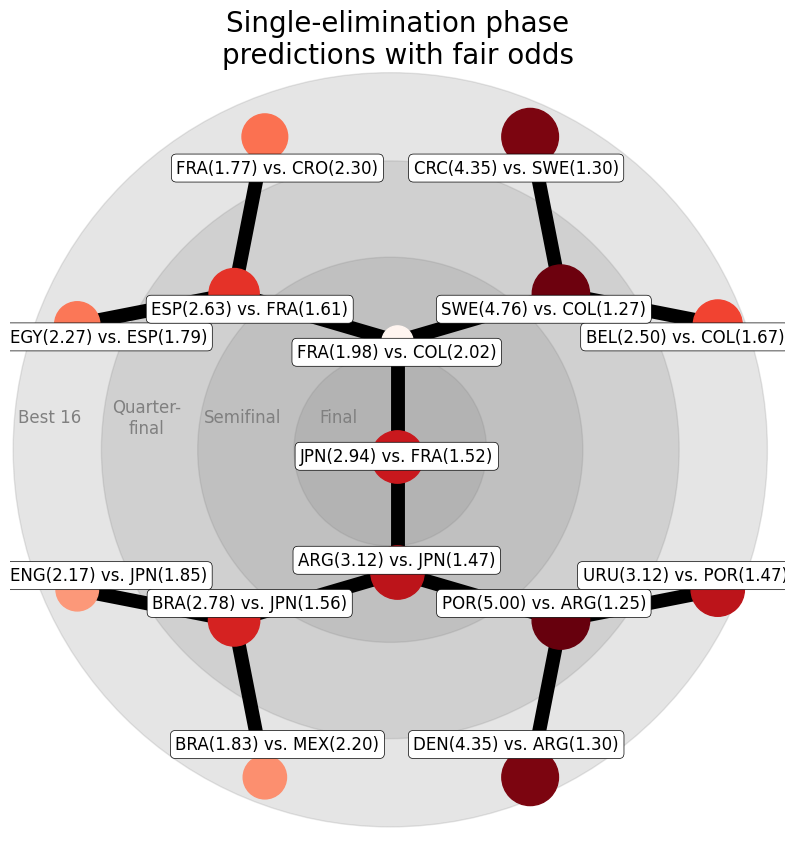

In [341]:
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

node_sizes = pd.DataFrame(list(reversed(odds)))
scale_factor = 0.3 # for visualization
G = nx.balanced_tree(2, 3)
pos = graphviz_layout(G, prog='twopi')
centre = pd.DataFrame(pos).mean(axis=1).mean()

plt.figure(figsize=(10, 10))
ax = plt.subplot(1,1,1)

# add circles 
circle_positions = [(235, 'black'), (180, 'blue'), (120, 'red'), (60, 'yellow')]
[ax.add_artist(plt.Circle((centre, centre), 
                          cp, color='grey', 
                          alpha=0.2)) for cp, c in circle_positions]

# draw first the graph
nx.draw(G, pos, 
        node_color=node_sizes.diff(axis=1)[1].abs().pow(scale_factor), 
        node_size=node_sizes.diff(axis=1)[1].abs().pow(scale_factor)*2000, 
        alpha=1, 
        cmap='Reds',
        edge_color='black',
        width=10,
        with_labels=False)

# draw the custom node labels
shifted_pos = {k:[(v[0]-centre)*0.9+centre,(v[1]-centre)*0.9+centre] for k,v in pos.items()}
nx.draw_networkx_labels(G, 
                        pos=shifted_pos, 
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5, alpha=1),
                        labels=dict(zip(reversed(range(len(labels))), labels)))

texts = ((10, 'Best 16', 'black'), (70, 'Quarter-\nfinal', 'blue'), (130, 'Semifinal', 'red'), (190, 'Final', 'yellow'))
[plt.text(p, centre+20, t, 
          fontsize=12, color='grey', 
          va='center', ha='center') for p,t,c in texts]
plt.axis('equal')
plt.title('Single-elimination phase\npredictions with fair odds', fontsize=20)
plt.show()
